
===== HOG Features =====

>>> Logistic Regression
Accuracy: 0.3854
              precision    recall  f1-score   support

       daisy       0.29      0.27      0.28       153
   dandelion       0.46      0.49      0.47       210
        rose       0.33      0.32      0.33       157
   sunflower       0.33      0.29      0.31       147
       tulip       0.43      0.49      0.46       197

    accuracy                           0.39       864
   macro avg       0.37      0.37      0.37       864
weighted avg       0.38      0.39      0.38       864

Cohen's Kappa: 0.2248
ROC-AUC: 0.6946
Total Misclassifications: 531/864

Class-wise Misclassifications:
daisy: 112 errors
dandelion: 107 errors
rose: 107 errors
sunflower: 105 errors
tulip: 100 errors


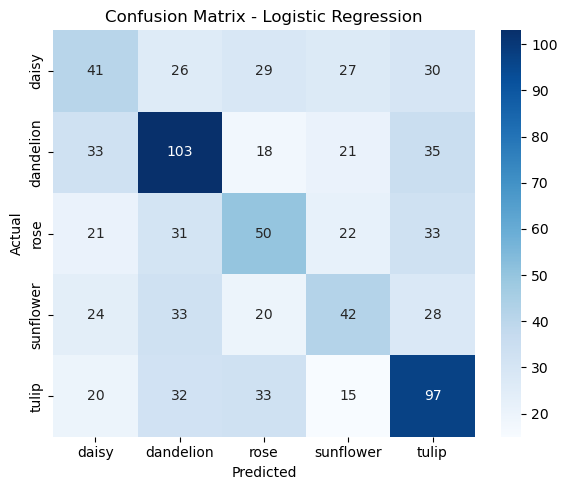


>>> KNN
Accuracy: 0.2917
              precision    recall  f1-score   support

       daisy       0.20      0.16      0.17       153
   dandelion       0.33      0.21      0.26       210
        rose       0.33      0.03      0.06       157
   sunflower       0.23      0.52      0.32       147
       tulip       0.40      0.52      0.45       197

    accuracy                           0.29       864
   macro avg       0.30      0.29      0.25       864
weighted avg       0.30      0.29      0.26       864

Cohen's Kappa: 0.1147
ROC-AUC: 0.5910
Total Misclassifications: 612/864

Class-wise Misclassifications:
daisy: 129 errors
dandelion: 166 errors
rose: 152 errors
sunflower: 70 errors
tulip: 95 errors


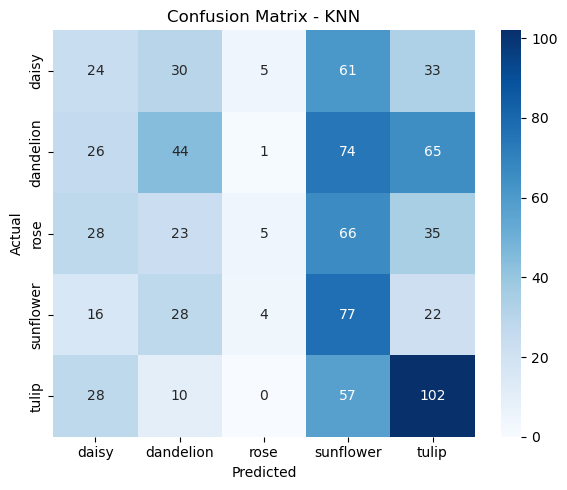


>>> Decision Tree
Accuracy: 0.2674
              precision    recall  f1-score   support

       daisy       0.22      0.22      0.22       153
   dandelion       0.31      0.33      0.32       210
        rose       0.24      0.23      0.23       157
   sunflower       0.20      0.20      0.20       147
       tulip       0.33      0.31      0.32       197

    accuracy                           0.27       864
   macro avg       0.26      0.26      0.26       864
weighted avg       0.27      0.27      0.27       864

Cohen's Kappa: 0.0785
ROC-AUC: 0.5376
Total Misclassifications: 633/864

Class-wise Misclassifications:
daisy: 119 errors
dandelion: 140 errors
rose: 121 errors
sunflower: 118 errors
tulip: 135 errors


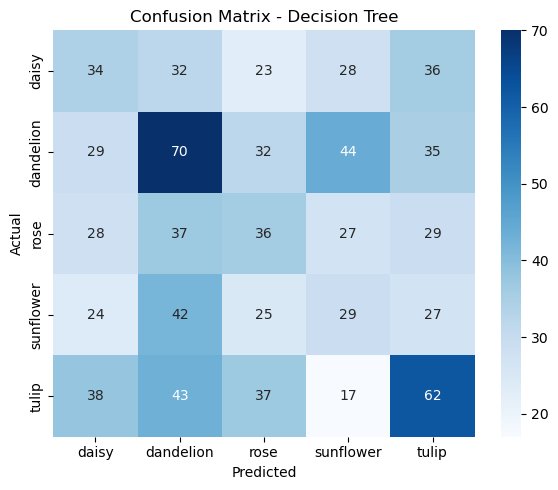


>>> Random Forest
Accuracy: 0.4144
              precision    recall  f1-score   support

       daisy       0.44      0.30      0.36       153
   dandelion       0.39      0.62      0.48       210
        rose       0.39      0.22      0.28       157
   sunflower       0.36      0.24      0.29       147
       tulip       0.48      0.56      0.52       197

    accuracy                           0.41       864
   macro avg       0.41      0.39      0.38       864
weighted avg       0.41      0.41      0.40       864

Cohen's Kappa: 0.2528
ROC-AUC: 0.7180
Total Misclassifications: 506/864

Class-wise Misclassifications:
daisy: 107 errors
dandelion: 79 errors
rose: 122 errors
sunflower: 111 errors
tulip: 87 errors


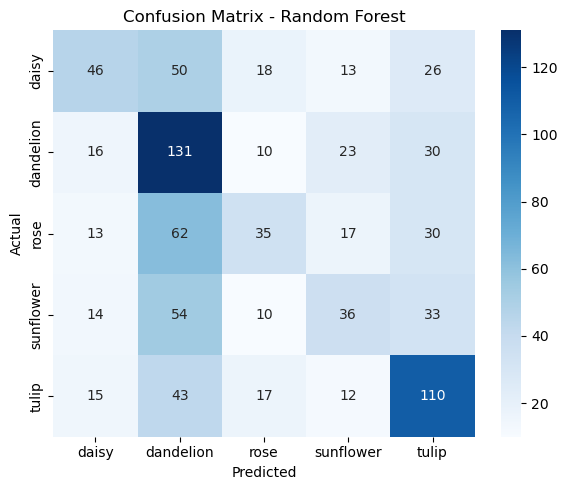

In [9]:
# hog_experiment.py
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    cohen_kappa_score, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# Load Dataset
# -----------------------------
DATASET_PATH = r"C:\Users\natra\Downloads\dl dataset\flowers"
IMG_SIZE = (128, 128)

def load_images(path=DATASET_PATH, img_size=IMG_SIZE):
    X, y = [], []
    class_names = os.listdir(path)
    class_names.sort()
    
    for label, folder in enumerate(class_names):
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, file))
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y), class_names

X, y, class_names = load_images()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# HOG Feature Extraction
# -----------------------------
def extract_hog(images):
    hog_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        feat, _ = hog(
            gray, orientations=9, pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), block_norm='L2-Hys',
            visualize=True
        )
        hog_features.append(feat)
    return np.array(hog_features)

X_train_hog = extract_hog(X_train)
X_test_hog = extract_hog(X_test)

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model(model, X_test, y_test, class_names, model_name):
    y_pred = model.predict(X_test)

    # --- Metrics ---
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")
    
    try:
        y_prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")
        print(f"ROC-AUC: {roc_auc:.4f}")
    except:
        pass

    errors = (y_test != y_pred).sum()
    print(f"Total Misclassifications: {errors}/{len(y_test)}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)

    # --- Class-wise Error Analysis ---
    errors_per_class = {}
    for idx, cls in enumerate(class_names):
        total = np.sum(cm[idx])  # total actual samples of this class
        correct = cm[idx][idx]
        wrong = total - correct
        errors_per_class[cls] = wrong
    print("\nClass-wise Misclassifications:")
    for cls, err in errors_per_class.items():
        print(f"{cls}: {err} errors")

    # --- Confusion Matrix Plot ---
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Train Models
# -----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

print("\n===== HOG Features =====")
for name, model in models.items():
    print(f"\n>>> {name}")
    model.fit(X_train_hog, y_train)
    evaluate_model(model, X_test_hog, y_test, class_names, name)



===== LBP Features =====

>>> Logistic Regression
Accuracy: 0.3461
              precision    recall  f1-score   support

       daisy       0.35      0.05      0.08       153
   dandelion       0.32      0.63      0.43       210
        rose       0.00      0.00      0.00       157
   sunflower       0.37      0.48      0.42       147
       tulip       0.37      0.45      0.40       197

    accuracy                           0.35       864
   macro avg       0.28      0.32      0.27       864
weighted avg       0.29      0.35      0.28       864

Cohen's Kappa: 0.1603
ROC-AUC: 0.6524
Total Misclassifications: 565/864

Class-wise Misclassifications:
daisy: 146 errors
dandelion: 77 errors
rose: 157 errors
sunflower: 76 errors
tulip: 109 errors


C:\Users\natra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\natra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\natra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


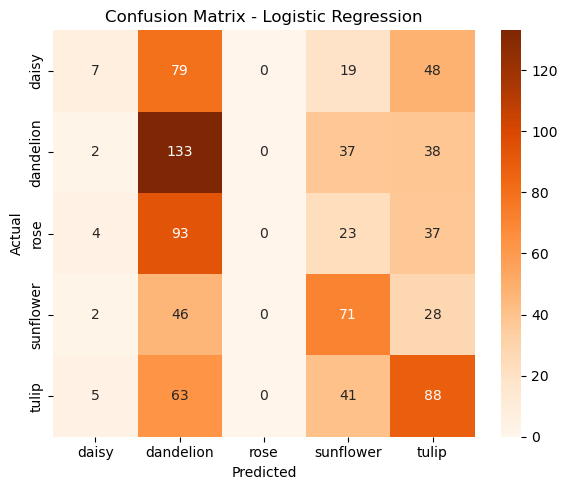


>>> KNN
Accuracy: 0.3704
              precision    recall  f1-score   support

       daisy       0.28      0.31      0.30       153
   dandelion       0.38      0.37      0.37       210
        rose       0.23      0.24      0.24       157
   sunflower       0.44      0.50      0.47       147
       tulip       0.52      0.42      0.46       197

    accuracy                           0.37       864
   macro avg       0.37      0.37      0.37       864
weighted avg       0.38      0.37      0.37       864

Cohen's Kappa: 0.2113
ROC-AUC: 0.6586
Total Misclassifications: 544/864

Class-wise Misclassifications:
daisy: 105 errors
dandelion: 133 errors
rose: 119 errors
sunflower: 73 errors
tulip: 114 errors


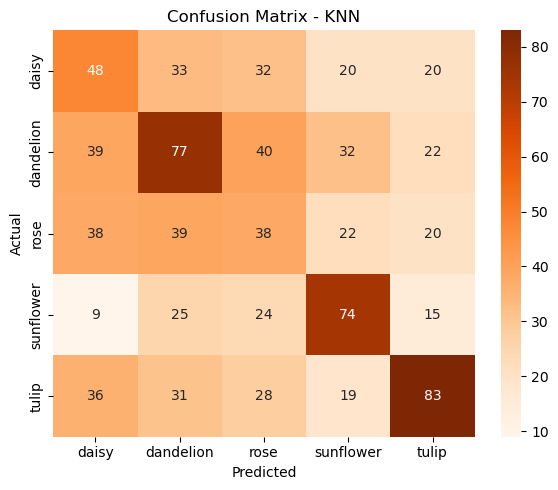


>>> Decision Tree
Accuracy: 0.3553
              precision    recall  f1-score   support

       daisy       0.27      0.27      0.27       153
   dandelion       0.39      0.37      0.38       210
        rose       0.28      0.29      0.29       157
   sunflower       0.35      0.39      0.37       147
       tulip       0.45      0.44      0.44       197

    accuracy                           0.36       864
   macro avg       0.35      0.35      0.35       864
weighted avg       0.36      0.36      0.36       864

Cohen's Kappa: 0.1911
ROC-AUC: 0.5943
Total Misclassifications: 557/864

Class-wise Misclassifications:
daisy: 112 errors
dandelion: 132 errors
rose: 112 errors
sunflower: 90 errors
tulip: 111 errors


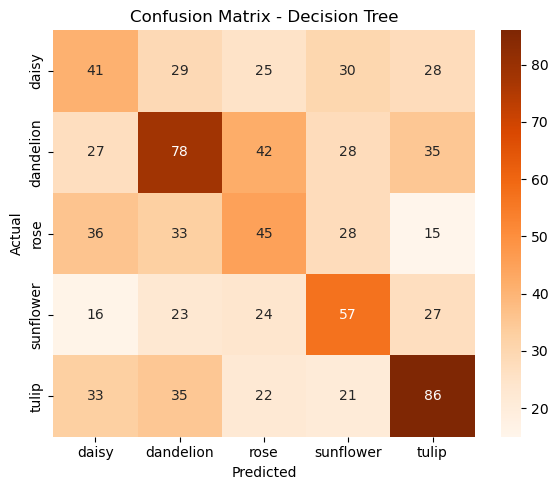


>>> Random Forest
Accuracy: 0.4340
              precision    recall  f1-score   support

       daisy       0.34      0.29      0.32       153
   dandelion       0.47      0.50      0.49       210
        rose       0.30      0.25      0.27       157
   sunflower       0.45      0.54      0.49       147
       tulip       0.53      0.53      0.53       197

    accuracy                           0.43       864
   macro avg       0.42      0.42      0.42       864
weighted avg       0.43      0.43      0.43       864

Cohen's Kappa: 0.2879
ROC-AUC: 0.7277
Total Misclassifications: 489/864

Class-wise Misclassifications:
daisy: 108 errors
dandelion: 104 errors
rose: 118 errors
sunflower: 67 errors
tulip: 92 errors


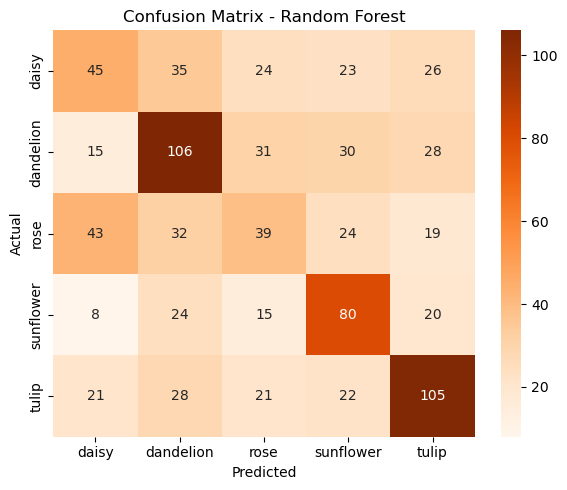

In [11]:
# lbp_experiment.py
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    cohen_kappa_score, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# Load Dataset
# -----------------------------
DATASET_PATH = r"C:\Users\natra\Downloads\dl dataset\flowers"
IMG_SIZE = (128, 128)

def load_images(path=DATASET_PATH, img_size=IMG_SIZE):
    X, y = [], []
    class_names = os.listdir(path)
    class_names.sort()
    
    for label, folder in enumerate(class_names):
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, file))
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y), class_names

X, y, class_names = load_images()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# LBP Feature Extraction
# -----------------------------
def extract_lbp(images, P=8, R=1):
    lbp_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, P, R, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        hist = hist.astype("float")
        hist /= hist.sum()
        lbp_features.append(hist)
    return np.array(lbp_features)

X_train_lbp = extract_lbp(X_train)
X_test_lbp = extract_lbp(X_test)

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model(model, X_test, y_test, class_names, model_name):
    y_pred = model.predict(X_test)

    # --- Metrics ---
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")
    
    try:
        y_prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")
        print(f"ROC-AUC: {roc_auc:.4f}")
    except:
        pass

    errors = (y_test != y_pred).sum()
    print(f"Total Misclassifications: {errors}/{len(y_test)}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)

    # --- Class-wise Error Analysis ---
    errors_per_class = {}
    for idx, cls in enumerate(class_names):
        total = np.sum(cm[idx])  # total samples of this class
        correct = cm[idx][idx]
        wrong = total - correct
        errors_per_class[cls] = wrong
    print("\nClass-wise Misclassifications:")
    for cls, err in errors_per_class.items():
        print(f"{cls}: {err} errors")

    # --- Confusion Matrix Plot ---
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Oranges",
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Train Models
# -----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

print("\n===== LBP Features =====")
for name, model in models.items():
    print(f"\n>>> {name}")
    model.fit(X_train_lbp, y_train)
    evaluate_model(model, X_test_lbp, y_test, class_names, name)



===== Edge Detection Features =====

>>> Logistic Regression
Accuracy: 0.2812
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00       153
   dandelion       0.28      0.65      0.39       210
        rose       0.00      0.00      0.00       157
   sunflower       0.00      0.00      0.00       147
       tulip       0.29      0.54      0.37       197

    accuracy                           0.28       864
   macro avg       0.11      0.24      0.15       864
weighted avg       0.13      0.28      0.18       864

Cohen's Kappa: 0.0586
ROC-AUC: 0.6082
Total Misclassifications: 621/864

Class-wise Misclassifications:
daisy: 153 errors
dandelion: 74 errors
rose: 157 errors
sunflower: 147 errors
tulip: 90 errors


C:\Users\natra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\natra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\natra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


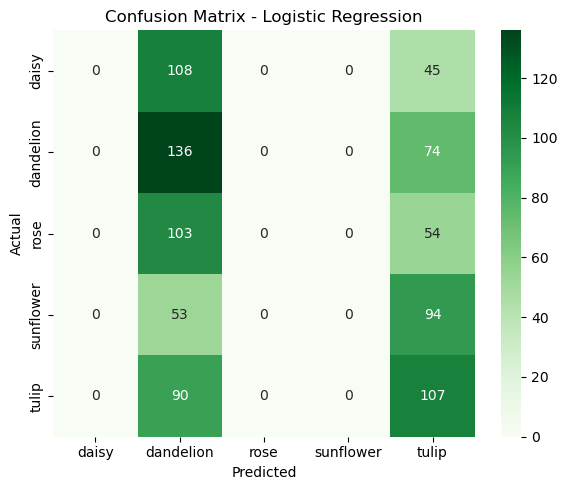


>>> KNN
Accuracy: 0.2361
              precision    recall  f1-score   support

       daisy       0.19      0.22      0.21       153
   dandelion       0.25      0.32      0.28       210
        rose       0.21      0.20      0.20       157
   sunflower       0.24      0.21      0.22       147
       tulip       0.29      0.20      0.24       197

    accuracy                           0.24       864
   macro avg       0.24      0.23      0.23       864
weighted avg       0.24      0.24      0.23       864

Cohen's Kappa: 0.0385
ROC-AUC: 0.5288
Total Misclassifications: 660/864

Class-wise Misclassifications:
daisy: 119 errors
dandelion: 142 errors
rose: 126 errors
sunflower: 116 errors
tulip: 157 errors


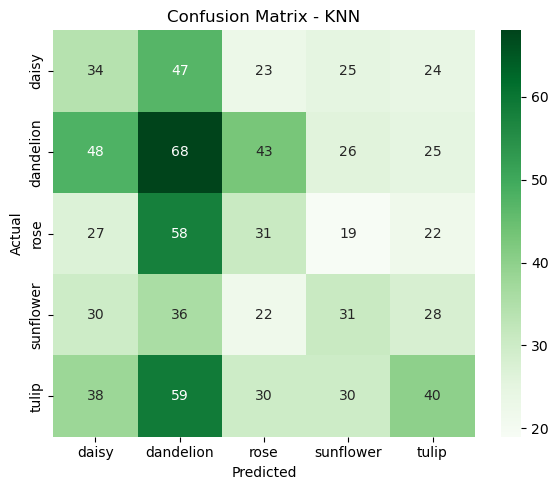


>>> Decision Tree
Accuracy: 0.2222
              precision    recall  f1-score   support

       daisy       0.24      0.27      0.25       153
   dandelion       0.24      0.27      0.25       210
        rose       0.16      0.17      0.16       157
   sunflower       0.24      0.20      0.22       147
       tulip       0.24      0.19      0.21       197

    accuracy                           0.22       864
   macro avg       0.22      0.22      0.22       864
weighted avg       0.22      0.22      0.22       864

Cohen's Kappa: 0.0225
ROC-AUC: 0.5185
Total Misclassifications: 672/864

Class-wise Misclassifications:
daisy: 111 errors
dandelion: 153 errors
rose: 131 errors
sunflower: 117 errors
tulip: 160 errors


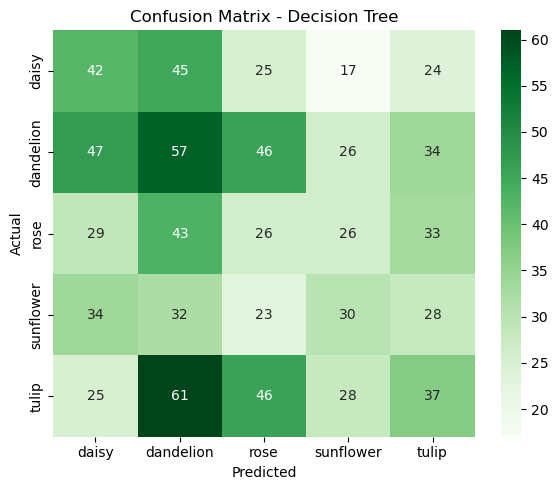


>>> Random Forest
Accuracy: 0.2384
              precision    recall  f1-score   support

       daisy       0.26      0.25      0.26       153
   dandelion       0.25      0.27      0.26       210
        rose       0.18      0.18      0.18       157
   sunflower       0.21      0.20      0.21       147
       tulip       0.27      0.27      0.27       197

    accuracy                           0.24       864
   macro avg       0.24      0.23      0.24       864
weighted avg       0.24      0.24      0.24       864

Cohen's Kappa: 0.0413
ROC-AUC: 0.5320
Total Misclassifications: 658/864

Class-wise Misclassifications:
daisy: 115 errors
dandelion: 154 errors
rose: 128 errors
sunflower: 117 errors
tulip: 144 errors


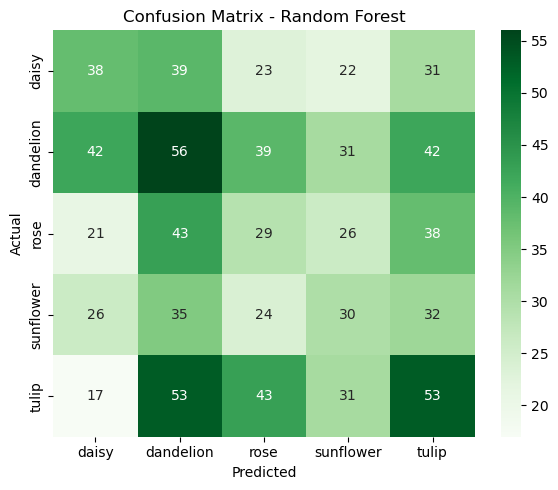

In [13]:
# edge_experiment.py
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    cohen_kappa_score, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# Load Dataset
# -----------------------------
DATASET_PATH = r"C:\Users\natra\Downloads\dl dataset\flowers"
IMG_SIZE = (128, 128)

def load_images(path=DATASET_PATH, img_size=IMG_SIZE):
    X, y = [], []
    class_names = os.listdir(path)
    class_names.sort()
    
    for label, folder in enumerate(class_names):
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, file))
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y), class_names

X, y, class_names = load_images()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Edge Feature Extraction
# -----------------------------
def extract_edges(images):
    edge_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        hist, _ = np.histogram(edges.ravel(), bins=256, range=(0, 256))
        hist = hist.astype("float")
        hist /= hist.sum()
        edge_features.append(hist)
    return np.array(edge_features)

X_train_edge = extract_edges(X_train)
X_test_edge = extract_edges(X_test)

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model(model, X_test, y_test, class_names, model_name):
    y_pred = model.predict(X_test)

    # --- Metrics ---
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")
    
    try:
        y_prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")
        print(f"ROC-AUC: {roc_auc:.4f}")
    except:
        pass

    errors = (y_test != y_pred).sum()
    print(f"Total Misclassifications: {errors}/{len(y_test)}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)

    # --- Class-wise Error Analysis ---
    errors_per_class = {}
    for idx, cls in enumerate(class_names):
        total = np.sum(cm[idx])  # total actual samples of this class
        correct = cm[idx][idx]
        wrong = total - correct
        errors_per_class[cls] = wrong
    print("\nClass-wise Misclassifications:")
    for cls, err in errors_per_class.items():
        print(f"{cls}: {err} errors")

    # --- Confusion Matrix Plot ---
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Greens",
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Train Models
# -----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

print("\n===== Edge Detection Features =====")
for name, model in models.items():
    print(f"\n>>> {name}")
    model.fit(X_train_edge, y_train)
    evaluate_model(model, X_test_edge, y_test, class_names, name)



===== VGG16 Deep Features =====

>>> Logistic Regression
Accuracy: 0.8310
              precision    recall  f1-score   support

       daisy       0.84      0.75      0.79       153
   dandelion       0.85      0.91      0.88       210
        rose       0.82      0.76      0.79       157
   sunflower       0.78      0.85      0.81       147
       tulip       0.85      0.85      0.85       197

    accuracy                           0.83       864
   macro avg       0.83      0.82      0.83       864
weighted avg       0.83      0.83      0.83       864

Cohen's Kappa: 0.7874
ROC-AUC: 0.9678
Total Misclassifications: 146/864

Class-wise Misclassifications:
daisy: 39 errors
dandelion: 18 errors
rose: 37 errors
sunflower: 22 errors
tulip: 30 errors


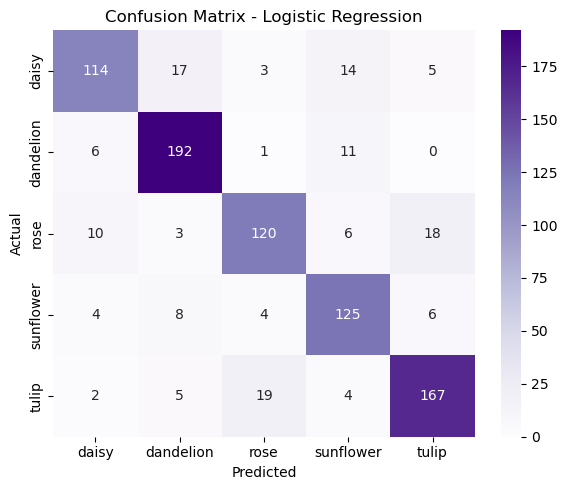


>>> KNN
Accuracy: 0.6620
              precision    recall  f1-score   support

       daisy       0.51      0.86      0.64       153
   dandelion       0.70      0.83      0.76       210
        rose       0.63      0.69      0.66       157
   sunflower       0.85      0.44      0.58       147
       tulip       0.86      0.48      0.62       197

    accuracy                           0.66       864
   macro avg       0.71      0.66      0.65       864
weighted avg       0.72      0.66      0.66       864

Cohen's Kappa: 0.5760
ROC-AUC: 0.9008
Total Misclassifications: 292/864

Class-wise Misclassifications:
daisy: 22 errors
dandelion: 36 errors
rose: 49 errors
sunflower: 83 errors
tulip: 102 errors


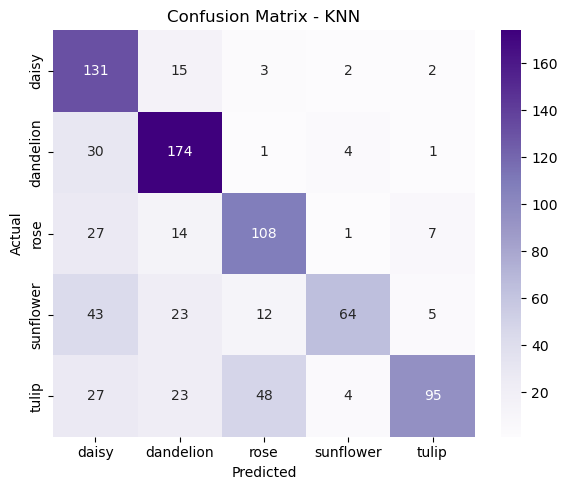


>>> Decision Tree
Accuracy: 0.5370
              precision    recall  f1-score   support

       daisy       0.54      0.48      0.51       153
   dandelion       0.62      0.69      0.65       210
        rose       0.48      0.48      0.48       157
   sunflower       0.42      0.39      0.41       147
       tulip       0.56      0.57      0.57       197

    accuracy                           0.54       864
   macro avg       0.52      0.52      0.52       864
weighted avg       0.53      0.54      0.53       864

Cohen's Kappa: 0.4166
ROC-AUC: 0.7034
Total Misclassifications: 400/864

Class-wise Misclassifications:
daisy: 80 errors
dandelion: 66 errors
rose: 81 errors
sunflower: 89 errors
tulip: 84 errors


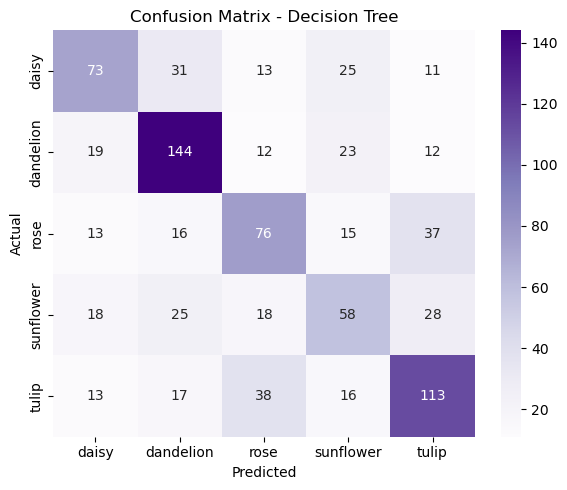


>>> Random Forest
Accuracy: 0.7720
              precision    recall  f1-score   support

       daisy       0.80      0.66      0.72       153
   dandelion       0.78      0.90      0.83       210
        rose       0.74      0.78      0.76       157
   sunflower       0.83      0.64      0.72       147
       tulip       0.75      0.81      0.78       197

    accuracy                           0.77       864
   macro avg       0.78      0.76      0.76       864
weighted avg       0.78      0.77      0.77       864

Cohen's Kappa: 0.7120
ROC-AUC: 0.9475
Total Misclassifications: 197/864

Class-wise Misclassifications:
daisy: 52 errors
dandelion: 21 errors
rose: 34 errors
sunflower: 53 errors
tulip: 37 errors


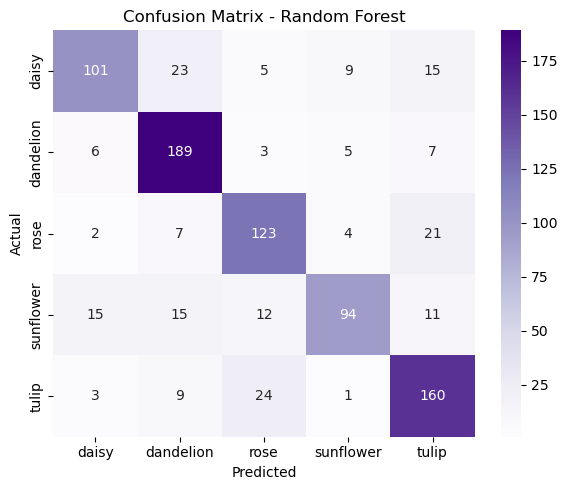

In [15]:
# vgg_experiment.py
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    cohen_kappa_score, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# Load Dataset
# -----------------------------
DATASET_PATH = r"C:\Users\natra\Downloads\dl dataset\flowers"
IMG_SIZE = (128, 128)

def load_images(path=DATASET_PATH, img_size=IMG_SIZE):
    X, y = [], []
    class_names = os.listdir(path)
    class_names.sort()
    
    for label, folder in enumerate(class_names):
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, file))
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y), class_names

X, y, class_names = load_images()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# VGG16 Feature Extraction
# -----------------------------
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
vgg_model.trainable = False

def extract_vgg_features(images):
    features = []
    for img in images:
        arr = img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr = preprocess_input(arr)
        feat = vgg_model.predict(arr, verbose=0)
        features.append(feat.flatten())
    return np.array(features)

X_train_vgg = extract_vgg_features(X_train)
X_test_vgg = extract_vgg_features(X_test)

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model(model, X_test, y_test, class_names, model_name):
    y_pred = model.predict(X_test)

    # --- Metrics ---
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")
    
    try:
        y_prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")
        print(f"ROC-AUC: {roc_auc:.4f}")
    except:
        pass

    errors = (y_test != y_pred).sum()
    print(f"Total Misclassifications: {errors}/{len(y_test)}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)

    # --- Class-wise Error Analysis ---
    errors_per_class = {}
    for idx, cls in enumerate(class_names):
        total = np.sum(cm[idx])  # total actual samples of this class
        correct = cm[idx][idx]
        wrong = total - correct
        errors_per_class[cls] = wrong
    print("\nClass-wise Misclassifications:")
    for cls, err in errors_per_class.items():
        print(f"{cls}: {err} errors")

    # --- Confusion Matrix Plot ---
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Purples",
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Train Models
# -----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

print("\n===== VGG16 Deep Features =====")
for name, model in models.items():
    print(f"\n>>> {name}")
    model.fit(X_train_vgg, y_train)
    evaluate_model(model, X_test_vgg, y_test, class_names, name)




Extracting HOG...

Extracting LBP...

Extracting Edge...

Extracting VGG16...


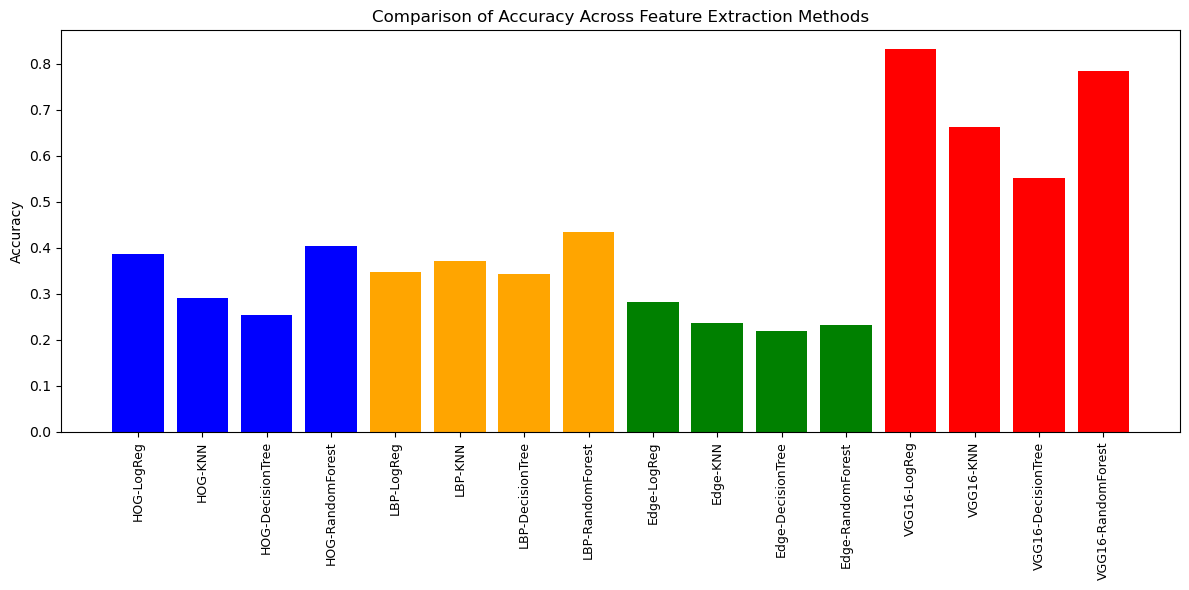

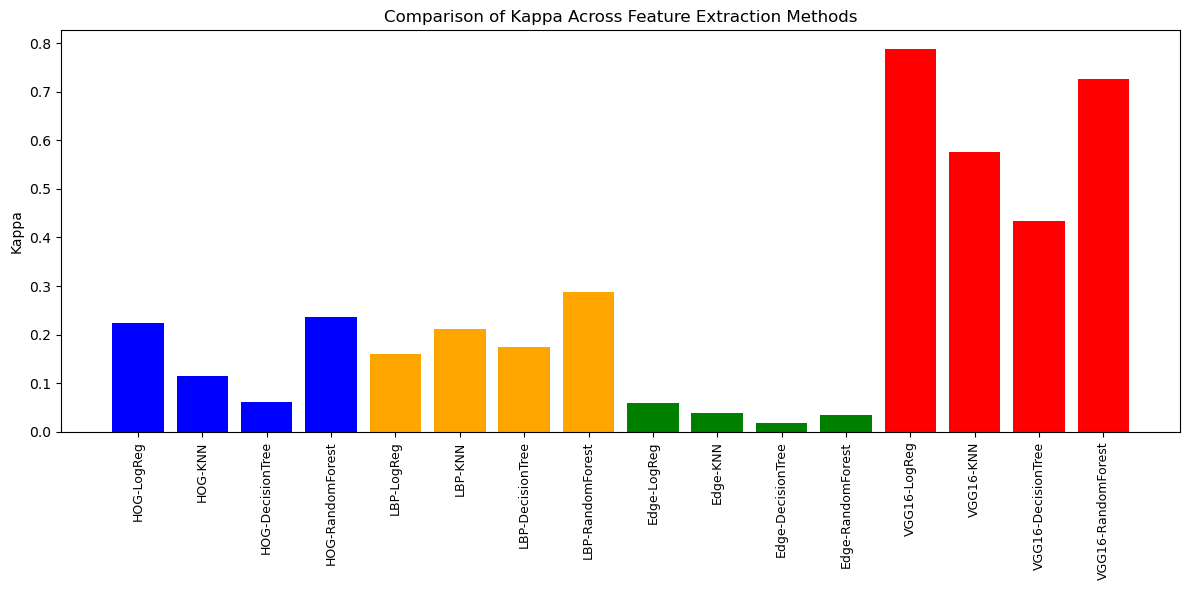

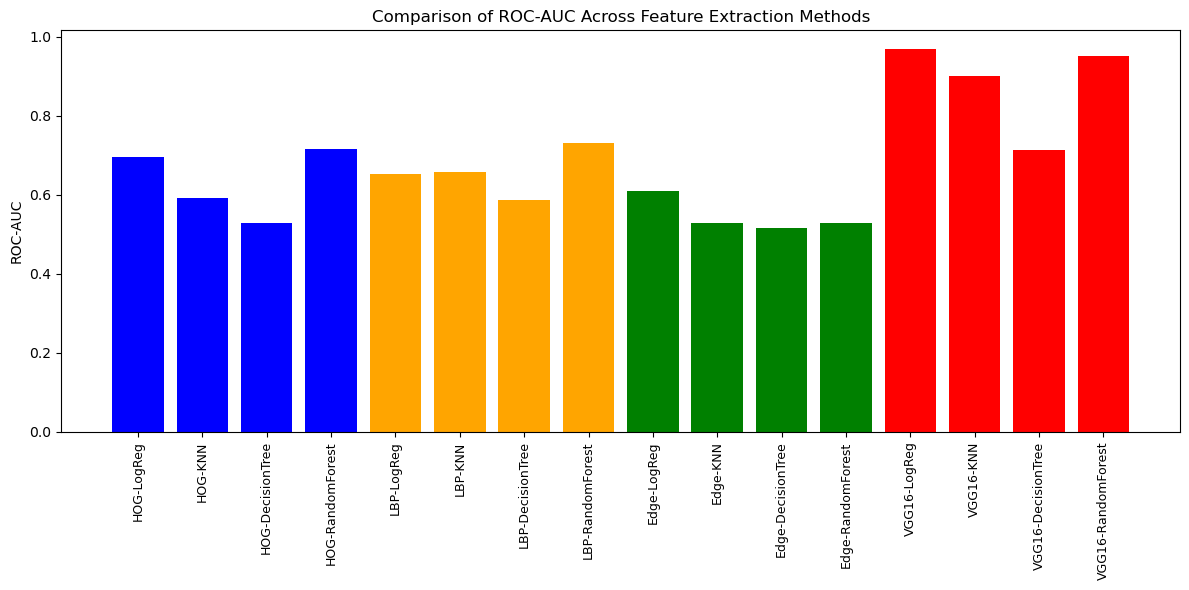

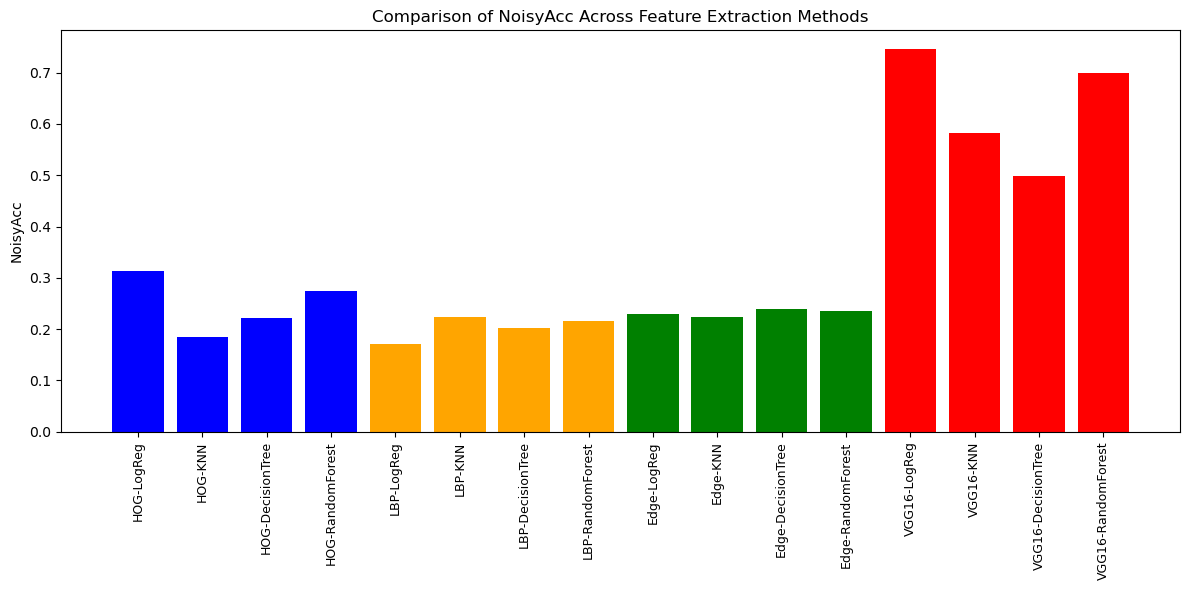


===== Summary Results =====
   Method         Model  Accuracy     Kappa   ROC-AUC  NoisyAcc  FeatureTime  \
0     HOG        LogReg  0.385417  0.224803  0.694597  0.312500    78.359805   
1     HOG           KNN  0.291667  0.114664  0.591015  0.184028    78.359805   
2     HOG  DecisionTree  0.253472  0.061352  0.528888  0.222222    78.359805   
3     HOG  RandomForest  0.402778  0.236946  0.716070  0.274306    78.359805   
4     LBP        LogReg  0.346065  0.160279  0.652412  0.170139     7.111043   
5     LBP           KNN  0.370370  0.211294  0.658567  0.223380     7.111043   
6     LBP  DecisionTree  0.342593  0.174839  0.585507  0.202546     7.111043   
7     LBP  RandomForest  0.434028  0.288452  0.731576  0.216435     7.111043   
8    Edge        LogReg  0.281250  0.058559  0.608193  0.229167     1.576094   
9    Edge           KNN  0.236111  0.038546  0.528754  0.224537     1.576094   
10   Edge  DecisionTree  0.218750  0.017754  0.515604  0.239583     1.576094   
11   Edge  

In [5]:
# comparison.py
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# Load Dataset
# -----------------------------
DATASET_PATH = r"C:\Users\natra\Downloads\dl dataset\flowers"
IMG_SIZE = (128, 128)

def load_images(path=DATASET_PATH, img_size=IMG_SIZE):
    X, y = [], []
    class_names = os.listdir(path)
    class_names.sort()
    for label, folder in enumerate(class_names):
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, file))
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y), class_names

X, y, class_names = load_images()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------------
# Feature Extraction Functions
# -----------------------------
def extract_hog(images):
    feats = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        f, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
        feats.append(f)
    return np.array(feats)

def extract_lbp(images, P=8, R=1):
    feats = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, P, R, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2))
        hist = hist.astype("float")
        hist /= hist.sum()
        feats.append(hist)
    return np.array(feats)

def extract_edges(images):
    feats = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        hist, _ = np.histogram(edges.ravel(), bins=256, range=(0, 256))
        hist = hist.astype("float")
        hist /= hist.sum()
        feats.append(hist)
    return np.array(feats)

vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
vgg_model.trainable = False
def extract_vgg_features(images):
    feats = []
    for img in images:
        arr = img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr = preprocess_input(arr)
        f = vgg_model.predict(arr, verbose=0)
        feats.append(f.flatten())
    return np.array(feats)

# -----------------------------
# Models
# -----------------------------
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100)
}

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_features(X_train_f, X_test_f, name):
    results = {}
    for mname, model in models.items():
        start_train = time.time()
        model.fit(X_train_f, y_train)
        end_train = time.time()

        start_pred = time.time()
        y_pred = model.predict(X_test_f)
        end_pred = time.time()

        acc = accuracy_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)
        try:
            y_prob = model.predict_proba(X_test_f)
            roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")
        except:
            roc_auc = np.nan

        results[mname] = {
            "Accuracy": acc,
            "Kappa": kappa,
            "ROC-AUC": roc_auc,
            "TrainTime": end_train - start_train,
            "TestTime": end_pred - start_pred
        }
    return results

# -----------------------------
# Robustness Test (Noise)
# -----------------------------
def add_noise(images, noise_factor=0.1):
    noisy = images + noise_factor * np.random.randn(*images.shape) * 255
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

X_test_noisy = add_noise(X_test)

# -----------------------------
# Run All Feature Methods
# -----------------------------
all_results = {}
feature_methods = {
    "HOG": extract_hog,
    "LBP": extract_lbp,
    "Edge": extract_edges,
    "VGG16": extract_vgg_features
}

for method, extractor in feature_methods.items():
    print(f"\nExtracting {method}...")
    start_feat = time.time()
    X_train_f = extractor(X_train)
    X_test_f = extractor(X_test)
    end_feat = time.time()
    feat_time = end_feat - start_feat

    # Evaluate on clean test set
    all_results[method] = evaluate_features(X_train_f, X_test_f, method)
    for m in all_results[method]:
        all_results[method][m]["FeatureTime"] = feat_time

    # Evaluate robustness (noisy test set)
    X_test_noisy_f = extractor(X_test_noisy)
    noisy_results = evaluate_features(X_train_f, X_test_noisy_f, method)
    for m in all_results[method]:
        all_results[method][m]["NoisyAcc"] = noisy_results[m]["Accuracy"]

# -----------------------------
# Plot Comparison Charts
# -----------------------------
colors = {"HOG": "blue", "LBP": "orange", "Edge": "green", "VGG16": "red"}
metrics = ["Accuracy", "Kappa", "ROC-AUC", "NoisyAcc"]

for metric in metrics:
    plt.figure(figsize=(12,6))
    vals, labels, c = [], [], []
    
    for method, res in all_results.items():
        for m in models.keys():
            vals.append(res[m][metric])
            labels.append(f"{method}-{m}")
            c.append(colors[method])
    
    plt.bar(labels, vals, color=c)
    plt.xticks(rotation=90, fontsize=9)
    plt.ylabel(metric)
    plt.title(f"Comparison of {metric} Across Feature Extraction Methods")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Print Summary Table
# -----------------------------
import pandas as pd
summary = []
for method, res in all_results.items():
    for m, scores in res.items():
        summary.append([method, m, scores["Accuracy"], scores["Kappa"], scores["ROC-AUC"],
                        scores["NoisyAcc"], scores["FeatureTime"], scores["TrainTime"], scores["TestTime"]])

df = pd.DataFrame(summary, columns=["Method","Model","Accuracy","Kappa","ROC-AUC","NoisyAcc",
                                    "FeatureTime","TrainTime","TestTime"])
print("\n===== Summary Results =====")
print(df)
